<a href="https://colab.research.google.com/github/JordanHoffmann3/Sim1ab/blob/master/Sim1_07Dec2020_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You are simulating the trajectory of 50 non-interacting particles.
Wall wavelength: 1.0 & amplitude: 0.5
Wall sinusoidal amplitude: 0.5 units of length
Lane average half-radius: 5 units of length
Simulation run duration: 100 units of time
Initial flow velocity: 2.5 units of velocity

Last particle:
Initial coordinates: 0.8490236663739539, 3.357876525742621
Initial velocity: 3.186323807470013, 1.0470076567943285
Initial velocity modulus: 3.3539356641766624
Number of collisions: 28
Final coordinates: 112.4334639462648, -4.084597348268501
Final velocity: 2.043944482030543, -2.6591681770457916
Final velocity modulus: 3.3539356641766616



The following plots pertain to all of the runs done for this
set of simulation parameters (lane geometry & particle
initialization), including the latest 50 particles.
 Total number of particles: <TBCompleted>


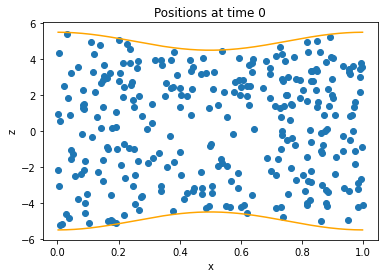

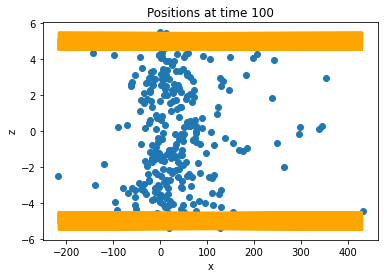

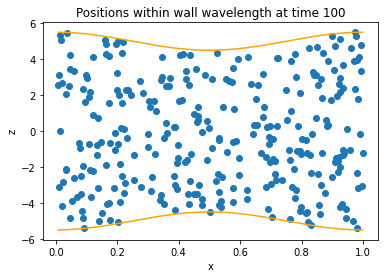

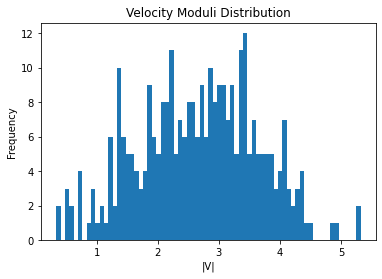

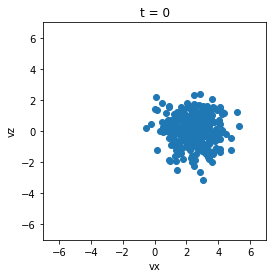

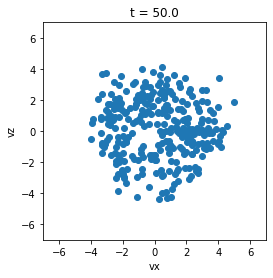

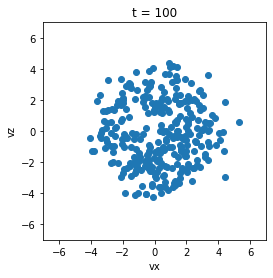

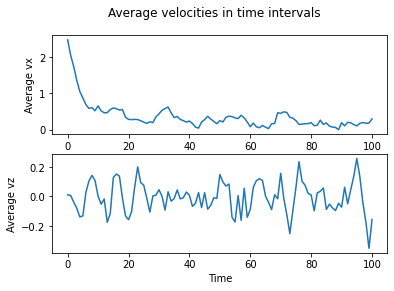

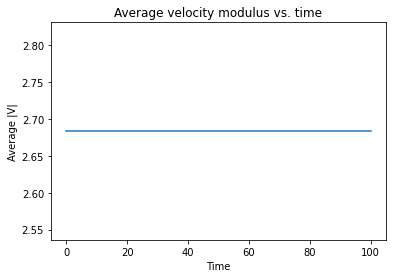

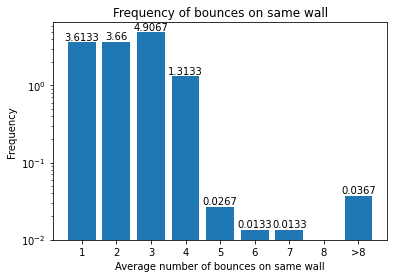

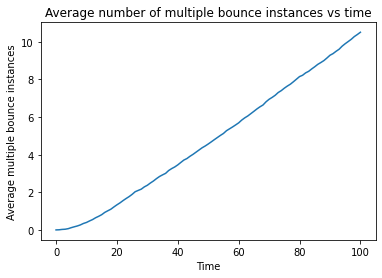

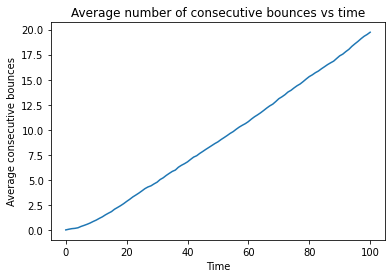

In [75]:
'''
Main program. Handles the overall running and initializations.
Sequence:
    1 - User can update the global simulation variables here if desired, 
    2 - Run the number of simulations in sequence
    3 - Analyse data and visualise the main information of interest

Written by Alec Lau in Q3-2020.  
Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

# Lane geometry .
lane_specs = dict(
    wall_wavelength = 1.0,      # In units of length (1.0 for normalized units)
    wall_amplitude = 0.5,       # In units of length
    avg_radius = 5              # In units of length
)

# Particle motion initialization specifications.
init_cnsts = dict(
    init_flow_vel = 2.5,        # In units of velocity
    vel_variance = 1.0          # In units of velocity
)

# Runtime specifications common to a series of simulations
run_specs = dict(
    single_run_time = 100,      # In units of time      
    num_time_ints = 100,
    precision = 1e-6,           # In units of length
    num_hist_bins = 70, 
    num_sim_runs = 50           # Number of particles simulated
)

# Output file name
file_name = ( "PSR_sim1_runData_" + str(lane_specs["wall_amplitude"]) + "_"    \
           + str(lane_specs["avg_radius"]) + "_"                               \
           + str(init_cnsts["init_flow_vel"]) + "_"                            \
           + str(run_specs["single_run_time"]) + ".csv" )

# Run the simulations
simulation_data = run_sims(lane_specs, init_cnsts, run_specs, file_name)

# Plot the last particle to ensure it looks correct
plot_last_trajectory(simulation_data, lane_specs, run_specs)

# Plot analysis of the simulations
analyze_and_visualize(simulation_data, lane_specs, init_cnsts, run_specs)

In [74]:
'''
0000000001111111111222222222233333333334444444444555555555566666666667777777777
1234567890123456789012345678901234567890123456789012345678901234567890123456789
                                                                       ^      ^
Simulation 1: Particle motion in lane with sinusoidal walls

This Python program simulates the flow of an arbitrary number of 
non-interacting particles in a conservative lane with sinusoidal walls.

Reference article: 
    A simulation of particle motion in a lane with sinusoidal walls
    Martin Storey and Alec Lau, 2020.
    ArXiv xxx.xxx.xxx

Program overview:
    1. Run the specified number of simulations, adding them to the  
        previous simulation runs for the same set of parameters, if 
        applicable.
    2. Display a sample trajectory from that series, the very last one. 
    3. Do a statistical analysis of all the runs done for this set of 
        parameters, i.e. this series of runs and every previous one 
        found in the data file; present some of the results graphically. 

Output:
    A file
    Some figures

To run:
    1. Execute first cell, and go to the bottom of the cell, follow 
        the link to obtain a password, enter the password and press 
        <return>
    2. After verifying that the simulation parameters are as desired, 
    execute the second cell.

In addition to the figures that appear, output files are available by
clicking on the folder icon on the left hand side of the Colab window. 

Main parameters:
Lane geometry:
    wall_wavelength = S in the article       
    wall_amplitude = A in the article
    avg_radius = Z0 in the article
Particle initialisation:
    init_flow_vel = Vflow in the article
    vel_variance = sigma^2 in the article
Simulation:
    single_run_time = T in the article
    num_sim_runs = N in the article
    precision = an indication of the precision of each collision point
Visualisation:
    num_hist_bins
    num_time_ints = 100        

Program written by Alec Lau with Martin Storey and Jordan Hoffmann 
in 2020.

'''
################################################################################
################################################################################
################################# Sim 1a #######################################
################################################################################
################################################################################

# Imports
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt 
from google.colab import drive 
import os
import csv
from datetime import datetime
drive.mount('/drive')

################################################################################
# Simulation running and handling
################################################################################

'''
Function run_sims.
Conducts the main handling of the simulation runs.

Parameters:     
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to give initial position and velocity.
- run_specs = Constants used in running the simulation.

Returns:
- data = The data from the simulation.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann):
- Cleaning code
'''

def run_sims(lane_specs, init_cnsts, run_specs, file_name):
    
    # Run the simulation for each particle
    for particle_number in range(0, run_specs["num_sim_runs"]):
        num_collisions = simulate_particle(lane_specs, init_cnsts, run_specs,  \
                                           file_name, particle_number)

    # Read the data from the file it is written into
    data = np.genfromtxt(file_name, delimiter = ",", names =                   \
            ["num_cols","time","x","z","vx","vz","particle_num"])[1:]

    return data

################################################################################

'''
Function initialize_particle_arrays. 
Assigns a random x and z position from a uniform distribution within 
the first one-wavelength cell of the lane. 
Assigns Rayleigh-distributed Vx and Vz velocity components  and adds 
on an initial flow rate in the X direction.
Also accepts user-specified positional and velocity components.

Parameters:
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to get the initial position and velocity.
- x_custom = Optional custom x coordinate.
- z_custom = Optional custom z coordinate.
- vx_custom = Optional custom x velocity component.
- vz_custom = Optional custom z velocity component.

Returns:
- init_x = Initial x coordinate.
- init_z = Initial z coordinate.
- init_vx = Initial x velocity component.
- init_vz = Initlal z velocity component.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def initialize_particle_arrays(lane_specs, init_cnsts, x_custom=None,          \
                               z_custom=None, vx_custom=None, vz_custom=None):
    
    # Generate a random X and Z component within the rectangle completely
    # enclosing the first wavelength, then redo both components if it lies
    # outside the wall (due to sinusoidal walls)
    init_x, init_z = x_custom, z_custom
    lane_diameter = 2*(lane_specs["wall_amplitude"] + lane_specs["avg_radius"])
    while True:
        if x_custom == None:
            # Random X coordinate from a uniform distribution
            init_x = lane_specs["wall_wavelength"]*np.random.random_sample()
        if z_custom == None:
            # Random Z coordinate from a uniform distribution 
            init_z = lane_diameter*(np.random.random_sample() - 0.5)

        max_init_z_range = wall_func(init_x, lane_specs)
        if np.abs(init_z) < max_init_z_range:
            break

    # X and Z components of the velocities have normal distribution with
    # 0 mean and the same variance (input parameter contained in init_cnsts). 
    # The X component then has an initial flow added to it
    init_vx, init_vz = vx_custom, vz_custom
    if vx_custom == None:
        init_vx = np.random.normal(scale = np.sqrt(init_cnsts["vel_variance"]))\
                  + init_cnsts["init_flow_vel"]
    if vz_custom == None:
        init_vz = np.random.normal(scale = np.sqrt(init_cnsts["vel_variance"]))
  
    return init_x, init_z, init_vx, init_vz

################################################################################

'''
Function simulate_particle
Simulates the movement of a single particle as a function of time as it
bounces off the walls etc.

Inputs:
- lane_specs = Constants of the geometry of the lane.
- init_cnsts = Constants used to give initial position and velocity.
- run_specs = Constants for the overall simulation running.
- file_name = Name of the file to write the data to.
- particle_number = Number which this particle is in the simulation - 
        ie tells us how many particles have already been simulated.
- x_custom = Custom x coordinate.
- z_custom = Custom z coordinate.
- vx_custom = Custom x component of velocity.
- vz_custom = Custom z component of velocity.

Returns:
- num_collisions = Number of times this particle has collided with a wall

Last modified Dec 07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def simulate_particle(lane_specs, init_cnsts, run_specs, file_name,            \
                      particle_number, x_custom=None, z_custom=None,           \
                      vx_custom=None, vz_custom=None):
    # We want to discretize time to be fine enough so that the simulation is 
    # useful, i.e. we want to be able to tell when a collision needs to be 
    # calculated
    x, z, vx, vz = initialize_particle_arrays(lane_specs, init_cnsts, x_custom,\
                                              z_custom, vx_custom, vz_custom)
    num_collisions = 0
    if not os.path.isfile(file_name):
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["collision number", "time of collision",          \
                             "x-coord", "z-coord", "x-velocity", "z-velocity", \
                             "date-time", "particle number"])
            file.close()
            print("File at: " + str(os.path))

    if vx == 0.0 and vz == 0.0:
        x, z, vx, vz = initialize_particle_arrays(lane_specs, init_cnsts,      \
                                    x_custom, z_custom, vx_custom, vz_custom)
        
    # Finding time step to be used. Added 1e-4 to the speed to ensure the 
    # denominator is never equal to 0
    speed = np.sqrt(vx**2 + vz**2) + 1e-4
    time_step =  get_time_step(speed, lane_specs)      

    prev_x = x
    prev_z = z

    # For error correction:
    prev_x_col = 0.0
    time = run_specs["single_run_time"]
    init_time = time
    with open(file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([num_collisions, 0.0, x, z, vx, vz,                    \
                         datetime.now(), particle_number+1])

        # Iterate through the particle's path using timesteps and 
        # calculate the position of the particle after each timestep 
        # until the simulation is finished.
        while time > 0:
            next_vx = vx
            next_vz = vz

            # Calculate time step again
            arb_min_speed = 5
            arb_scale_factor = 50
            speed = np.sqrt(vx**2 + vz**2) + 1e-4
            time_step =  get_time_step(speed, lane_specs) 

            # Ensures the final coordinate is recorded regardless of rounding
            if time < time_step:
                time_step = time    

            next_x = prev_x + vx*time_step
            next_z = prev_z + vz*time_step

            # Check to see if this step is actually a step over a wall, and 
            # hence a collision
            if abs(next_z) >= wall_func(next_x, lane_specs):
                # Get new coordinates, velocities, and collision coordinates
                next_x, next_z, x_col, z_col, next_vx, next_vz, time_col =     \
                    collision(lane_specs, run_specs, prev_x, prev_z, next_vx,  \
                              next_vz, time_step, prev_x_col)
                    
                # For error correction
                prev_x_col = x_col
                num_collisions += 1

                # Add this new data to our arrays
                writer.writerow([num_collisions, init_time-time+time_col,      \
                                 x_col, z_col, next_vx, next_vz,               \
                                 datetime.now(), particle_number+1])

                # If it's the remaining time, record where it ends up instead 
                # of where it hits
                if time == time_step:
                    writer.writerow([num_collisions, init_time, next_x,        \
                                     next_z, next_vx, next_vz, datetime.now(), \
                                     particle_number+1])
                    
                vx = next_vx
                vz = next_vz

            elif time == time_step:
                # Record final coordinate if our remaining time is less than 
                # what our calculated time_step would be, AND if there was no 
                # collision.
                writer.writerow([num_collisions, init_time, next_x,            \
                                 next_z, next_vx, next_vz, datetime.now(),     \
                                 particle_number+1])
                
            else: 
                # Check if it's crossing the other boundary, then we can skip a 
                # lot of computations
                if abs(prev_z) >= (lane_specs["avg_radius"]                    \
                        - lane_specs["wall_amplitude"]) and ((abs(next_z))     \
                        < (lane_specs["avg_radius"] 
                        - lane_specs["wall_amplitude"])):

                    # Lower wall to upper wall
                    if prev_z < 0:
                        next_x = (lane_specs["avg_radius"]                     \
                                - lane_specs["wall_amplitude"]                 \
                                + next_vz*prev_x/next_vx - prev_z)             \
                                * next_vx/next_vz
                        next_z = lane_specs["avg_radius"]                      \
                                - lane_specs["wall_amplitude"]
                    
                    # Upper wall to lower wall
                    else:
                        next_x = (-lane_specs["avg_radius"]                    \
                                + lane_specs["wall_amplitude"]                 \
                                + next_vz*prev_x/next_vx - prev_z)             \
                                * next_vx/next_vz 
                        next_z = -lane_specs["avg_radius"]                     \
                                + lane_specs["wall_amplitude"]

                    # We now have our new coordinates - we skipped across the 
                    # gap to the other side of the tube now we have to 
                    # calculate how much time that took
                    distance = np.sqrt((next_x-prev_x)**2 + (next_z-prev_z)**2)
                    speed = np.sqrt(next_vx**2 + next_vz**2)
                    time_step = distance / speed

                    # Check to see if this time difference is larger than the 
                    # time left. If so, just travel with time left
                    if time_step > time:
                        writer.writerow([num_collisions, init_time,            \
                                        prev_x + next_vx*time, prev_z +        \
                                        next_vz*time, next_vx, next_vz,        \
                                        datetime.now(), particle_number+1])
                        time_step = time

            prev_x = next_x
            prev_z = next_z

            time -= time_step

    return num_collisions

###############################################################################

'''
Function collision.
Determines the next collision point coordinates of the particle with the 
sinusoidal walls.

Inputs:
- lane_specs = Constants of the lane geometry.
- run_specs = Constants of the run parameters.
- x = The x coordinate (before the collision).
- z = The z coordinate (before the collision).
- vx = The x velocity before the collision.
- vz = The z velocity before the collision.
- time_step = The time_step of the simulation.
- prev_x_col = The x coordinate of the previous collision point.

Returns:
- x_after = The x coordinate after the collision.
- z_after = The z coordinate after the collision.
- x_col = The x coordinate of the collision point.
- z_col = The z coordinate of the collision point.
- vx_after = The x velocity after the collision.
- vz_after = The z velocity after the collision.
- time_col = The time taken to get to the collision point.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def collision(lane_specs, run_specs, x, z, vx, vz, time_step, prev_x_col):

    # Find where the particle hits the wall using scipy's fsolve.
    x_col = 0.0
    z_col = 0.0

    if vx == 0:
        x_col = x
        z_col = z/abs(z) * wall_func(x, lane_specs)
    else:
        # Define the position function given the data. We want to find 
        # when the wall function - position function = 0. x-intersect 
        # is the x coordinate of the intersection (evaluation) point.
        def intersect_top(x_intersect):
            return wall_func(x_intersect, lane_specs)                          \
                   - linear(vz/vx, x, z, x_intersect)

        # Account for bottom wall too.
        def intersect_bot(x_intersect):
            return - wall_func(x_intersect, lane_specs)                        \
                   - linear(vz/vx, x, z, x_intersect)
    
        # Check for a collision with the top wall
        if z > 0:
            x_col = fsolve(intersect_top, x, xtol = run_specs["precision"])[0]
            if abs(x_col - prev_x_col) < run_specs["precision"]:
                x_col = fsolve(intersect_top, x + vx*time_step*1.5,            \
                               xtol = run_specs["precision"])[0]
                                     
            z_col = wall_func(x_col, lane_specs)

        # Otherwise, collision with the bottom wall
        else:
            x_col = fsolve(intersect_bot, x, xtol = run_specs["precision"])[0]
            if abs(x_col - prev_x_col) < run_specs["precision"]:
                x_col = fsolve(intersect_bot, x + vx*time_step*1.5,            \
                               xtol = run_specs["precision"])[0]
                                     
            z_col = -wall_func(x_col, lane_specs)

    # We want to bounce the particle off the wall's tangent line at the 
    # collision point.
    tangent_slope = - lane_specs["wall_amplitude"]                             \
                    * (2*np.pi/lane_specs["wall_wavelength"])                  \
                    * np.sin(2*np.pi*x_col/lane_specs["wall_wavelength"])

    # This entails us reflecting the velocity about a unit vector normal to the 
    # tangent point thus we need the angle. Since we have the slope, the angle 
    # is arctan of that (arctan(slope)).

    # The change in x of the UNIT tangent vector is then cos(arctan(slope)), or 
    # 1/(1+slope^2). So, the change in x of the UNIT NORMAL vector is then
    # sin(arctan(slope)), or slope/(1+slope^2)
    unit_norm_x = tangent_slope / np.sqrt(1 + tangent_slope**2)

    # The change in z of the UNIT tangent vector is then sin(arctan(slope)), or 
    # slope/(1+slope^2). So, the change in z of the UNIT NORMAL vector is then 
    # -cos(arctan(slope)), or -1/(1+slope^2)

    # This was assuming the normal vector will point down, i.e. rotated the 
    # tangent vector at the top wall by -pi/2 radians. If the particle hits the 
    # lower wall, we need to rotate the tangent vector by +pi/2 radians instead, 
    # hence the factor of z/abs(z) at the end
    unit_norm_z = -1/np.sqrt(1+tangent_slope**2) * z/abs(z)
  
    # Once we have our unit normal vector N, the formula for the reflected
    # velocity is -2(N dot V)N - V
    vx_after = -2*(unit_norm_x*vx + unit_norm_z*vz)*unit_norm_x + vx
    vz_after = -2*(unit_norm_x*vx + unit_norm_z*vz)*unit_norm_z + vz

    # Now we need to find the distance traveled after the collision, as the 
    # collision is in the middle of the current time_step. Take the distance from 
    # the previous point to the collision, divide by the magnitude of the 
    # velocity, and subtract this from the time_step
    time_col = np.sqrt( ((x-x_col)**2 + (z-z_col)**2) / (vx**2+vz**2) )
    time_left = time_step - time_col

    x_after = x_col + vx_after*time_left
    z_after = z_col + vz_after*time_left

    return x_after, z_after, x_col, z_col, vx_after, vz_after, time_col

################################################################################
# Helper functions
################################################################################

'''
Function linear.
Calculates the z coordinate for a corresponding x coordinate on a straight
line given the gradient and another point. (z = m*(x - x_0) + z_0)

Parameters:
- slope = Gradient of the line (m).
- x_start = The x coordinate of a known point on the line (corr. to z_start).
- z_start = The z coordinate of a known point on the line (corr. to x_start).
- x_end = The x coordinate at which we wish to evaluate the z coordinate.

Returns:
- z_end = The z coordinate of the point corresponding to x_end.

Written by Alec Lau in Q3-2020

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def linear(slope, x_start, z_start, x_end):
    return slope * (x_end - x_start) + z_start

################################################################################

'''
Function wall_func.
Gives the radius of the lane at a particular x coordinate. This is 
necessary as the radius is larger at a sinusoidal 'peak' and smaller at
a sinusoidal 'trough'.

Inputs:
- x = The x coordinate in question.
- lane_specs = Constants of the geometry of the lane.

Returns:
- z = The lane radius at the corresponding x coordinate.

Last modified Dec 07, 2020 (Jordan Hoffmann)
- Cleaning code
'''
def wall_func(x, lane_specs):
    return lane_specs["avg_radius"] + lane_specs["wall_amplitude"]             \
           * np.cos(2*np.pi*x/lane_specs["wall_wavelength"])

################################################################################

'''
Function get_time_step.
Gets the time step to be used in the numerical iterations.

Inputs:
- speed = Speed of the particle.
- lane_specs = Constants of the lane geometry.

Returns:
- time_step = The calculated time step.

Last modified Dec 07, 2020 (Jordan Hoffmann)
'''

def get_time_step(speed, lane_specs):
    arb_min_speed = 5.0
    arb_scale_factor = 50.0
    time_step =  min(lane_specs["wall_wavelength"]/arb_min_speed,              \
                     lane_specs["wall_wavelength"]/(speed*arb_scale_factor))  
    
    return time_step

################################################################################
################################################################################
################################# Sim 1b #######################################
################################################################################
################################################################################

# Additional Imports for graphing and visualization
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook()

################################################################################
# Main methods for Sim1b
################################################################################

'''
Function analyze_and_visualize.
Analyzes the code and produces visualizations of the results

Parameters:
- data = The data from the simulation conducted.
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to get the initial position and velocity.
- run_specs = Constants for the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def analyze_and_visualize(data, lane_specs, init_cnsts, run_specs):
    
    print("\nThe following plots pertain to all of the runs done for this\n"   \
        + "set of simulation parameters (lane geometry & particle\n"           \
        + "initialization), including the latest "                             \
        + str(run_specs["num_sim_runs"]) + " particles.\n Total number of "    \
        + "particles: <TBCompleted>")
    
    # Plot initial positions.
    plot_positions(data, 0, lane_specs) 
    # Plot final positions.                                     
    plot_positions(data, run_specs["single_run_time"], lane_specs)
    # Plot final positions relative to a wavelength.
    plot_positions(data, run_specs["single_run_time"], lane_specs,             \
                   lane_specs["wall_wavelength"])   
      
    # Plot speeds as a histogram.
    plot_velocity_moduli(data, run_specs["num_hist_bins"])
    # Plot initial velocity distribution.
    plot_velocity(data, 0, init_cnsts)
    # Plot intermediate velocity distribution.
    plot_velocity(data, run_specs["single_run_time"]/2, init_cnsts)
    # Plot final velocity distribution.
    plot_velocity(data, run_specs["single_run_time"], init_cnsts)
    # Plot average velocities as a function of time.
    plot_avg_velocities(data, lane_specs, init_cnsts, run_specs)
    # Plot the number of bounces as a histogram.
    plot_bounces(data, run_specs["single_run_time"], run_specs)

    return

################################################################################
# Plotting functions
################################################################################

'''
Function plot_last_trajectory.
Creates a plot of the trajectory of a single particle (the last in the file).

Parameters:
- data = The data from the simulation.
- lane_specs = Constants of the lane geometry.
- run_specs = Constants used in the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_last_trajectory(data, lane_specs, run_specs):
    index = -1
    for time in reversed(data["time"]):
        if time == 0.0:
            break
        index -= 1

    print("You are simulating the trajectory of "                              \
          + str(run_specs["num_sim_runs"]) + " non-interacting particles.")
    print("Wall wavelength: " + str(lane_specs["wall_wavelength"])             \
          + " & amplitude: " + str(lane_specs["wall_amplitude"]))
    print("Wall sinusoidal amplitude: " + str(lane_specs["wall_amplitude"])    \
          + " units of length")
    print("Lane average half-radius: " + str(lane_specs["avg_radius"])         \
          + " units of length")
    print("Simulation run duration: " + str(run_specs["single_run_time"])      \
          + " units of time")
    print("Initial flow velocity: " + str(init_cnsts["init_flow_vel"])         \
          + " units of velocity")
    print()
    print("Last particle:")
    print("===============")
    print("Initial coordinates: " + str(data["x"][index]) + ", "               \
          + str(data["z"][index]))
    print("Initial velocity: " + str(data["vx"][index]) + ", "                 \
          + str(data["vz"][index]))
    print("Initial velocity modulus: "+str(np.sqrt(data["vx"][index]**2        \
          + data["vz"][index]**2)))
    print("Number of collisions: " + str(int(data["num_cols"][-1])))
    print("Final coordinates: " + str(data["x"][-1]) + ", "                    \
          + str(data["z"][-1]))
    print("Final velocity: " + str(data["vx"][-1]) + ", "                      \
          + str(data["vz"][-1]))
    print("Final velocity modulus: " + str(np.sqrt(data["vx"][-1]**2           \
          + data["vz"][-1]**2)))

    x_array = data["x"][index:-1]
    z_array = data["z"][index:-1]
    x_max = np.amax(x_array)
    x_min = np.amin(x_array)
    x_abs_max = max(x_max, x_min + 30*lane_specs["wall_wavelength"])
    x_coords = np.linspace(x_min, x_abs_max, max(10000,len(x_array)))

    TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,hover"
    p1 = figure(title = "Example trajectory: very last particle in this set "  \
                + "of simulation runs:", tools = TOOLS, plot_width = 1000,     \
                plot_height = 400)

    p1.line(x_array, z_array, color = "blue")
    p1.line(x_coords, wall_func(x_coords, lane_specs), color = "orange")
    p1.line(x_coords, -wall_func(x_coords, lane_specs), color = "orange")
    source = dict(
        hover_x = x_array,
        hover_z = z_array
    )

    p1.add_tools(HoverTool(tooltips=[("(x,y)", "($hover_x, $hover_z)")]))
    show(p1)

    return

################################################################################

'''
Function plot_velocity_moduli.
Plots the modulus of the particles' velocities as a histogram.

Parameters:
- data = The data to be plotted.
- bin_number = The number of bins to be used in the histogram.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity_moduli(data, bin_number):
    moduli = []
    index = 0
    for i in data["num_cols"]:
        if i == 0:
            moduli.append(np.sqrt(data["vx"][index]**2 + data["vz"][index]**2))
        index += 1

    plt.hist(moduli, bins = bin_number)
    plt.xlabel("|V|")
    plt.ylabel("Frequency")
    plt.title("Velocity Moduli Distribution")
    plt.show()

    return

################################################################################

'''
Function plot_positions.
Plots the positions of all particles at a specified time.

Parameters:
- data = The data from the simulation.
- time = Time at which the 'snapshot' is taken.
- lane_specs = Constants of the lane geometry.
- domain (optional) = By default everything. If given a value, finds
    the positions in some repeating domain, e.g. how the positions
    are situated in one wavelength.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
- Combining plot_positions and plot_positions_in_domain
'''

def plot_positions(data, time, lane_specs, domain = None):
    x, z = give_positions(data, time)

    # Check if a domain is given
    if domain != None:
        title = "Positions within wall wavelength at time " + str(time)
        for i in range(0, len(x)):
            x[i] = x[i] % domain
    else:
        title = "Positions at time " + str(time)

    plt.scatter(x, z)
    num_points = int(round(10*(np.amax(x) - np.amin(x))                        \
                          /lane_specs["wall_wavelength"]))
    wall_coords = np.linspace(np.amin(x), np.amax(x), max(500, num_points))
    plt.plot(wall_coords, wall_func(wall_coords, lane_specs), color="orange")
    plt.plot(wall_coords, -wall_func(wall_coords, lane_specs), color="orange")
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(title)
    plt.show()

    return

################################################################################

'''
Function give_positions.
Finds the positions of each of the particles at a specified time.

Parameters:
- data = The data to be analyzed (from the simulation).
- time = The time at which the particles' position is to be found

Returns:
- x = All of the x positions of the particles at the given time.
- z = All of the z positions of the particles at the given time.

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def give_positions(data, time):
    x = []
    z = []
    index = 0
    for i in data["time"]:
        if i == time:
            x.append(data["x"][index])
            z.append(data["z"][index])
        index += 1

    return x, z

################################################################################

'''
Function plot_velocity.
Plots the velocities of all particles at a given time. The velocities are
decomposed into their x and z components and then these are plotted as
a scatter plot.

Parameters:
- data = The data from the simulation.
- time = The time at which we are taking the 'snapshot'.
- init_cnsts = Constants used to give the initial positions and velocities.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_velocity(data, time, init_cnsts):
    vx = []
    vz = []
    for index in range(0, len(data["time"]) - 1):
        time_curr = data["time"][index]
        timeNext = data["time"][index+1]
        if (time >= time_curr) and (timeNext >= time):
            vx.append(data["vx"][index])
            vz.append(data["vz"][index])
    
    # Below ensures the scaling of the three scatter plots are the same:
    max_c = np.ceil(init_cnsts["init_flow_vel"] + 4*init_cnsts["vel_variance"])
    min_c = -1*max_c
    plt.figure(figsize=(4,4))
    plt.scatter(vx, vz)
    plt.xlabel("vx"), plt.ylabel("vz")
    plt.xlim(min_c, max_c), plt.ylim(min_c, max_c)
    plt.title("t = " + str(time))
    plt.show()

    return

################################################################################

'''
Function plot_avg_velocities.
Plots the average velocities of all particles as a function of time.

Parameters:
- data = The data from the simulation.
- lane_specs = Constants of the lane geometry.
- init_cnsts = Constants used to give initial positions and velocities.
- run_specs = Constants used in the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_avg_velocities(data, lane_specs, init_cnsts, run_specs): 
    num_sims = 0
    time = run_specs["single_run_time"]
    avg_vx = np.zeros(run_specs["num_time_ints"]+1)
    avg_vz = np.zeros(run_specs["num_time_ints"]+1)
    avg_moduli = np.zeros(run_specs["num_time_ints"]+1)
    interval_idx = 0
    time_interval = time/run_specs["num_time_ints"]

    for index in range(0, len(data["time"])):
        time_curr = data["time"][index]
        if time_curr == 0:
            num_sims += 1
            interval_idx = 0
        else:
            while interval_idx*time_interval <= time_curr:
                avg_vx[interval_idx] += data["vx"][index-1]
                avg_vz[interval_idx] += data["vz"][index-1]
                avg_moduli[interval_idx] += np.sqrt(data["vx"][index-1]**2     \
                                            + data["vz"][index-1]**2)
                interval_idx += 1

    avg_vx /= num_sims
    avg_vz /= num_sims
    avg_moduli /= num_sims
  
    time_coords = np.linspace(0.0, time, run_specs["num_time_ints"]+1)
  
    # Add to file
    new_file_name = "PSR_sim1_analysis_" + str(lane_specs["wall_amplitude"])   \
                    + "_" + str(lane_specs["avg_radius"]) + "_"                \
                    + str(init_cnsts["init_flow_vel"])+ "_" + str(time) + ".csv"

    if os.path.isfile(new_file_name):
        os.remove(new_file_name)

    with open(new_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow("Data provided in order:")
        writer.writerow("total number of particles, time, average vx, average" \
                        + " vz")
        writer.writerow([num_sims])
        writer.writerow(time_coords)
        writer.writerow(avg_vx)
        writer.writerow(avg_vz)
        file.close()
  
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Average velocities in time intervals")
    ax2.set(xlabel = "Time")
    ax1.set(ylabel = "Average vx"), ax2.set(ylabel = "Average vz")                           
    ax1.plot(time_coords, avg_vx)
    ax2.plot(time_coords, avg_vz)
    plt.show(fig)

    plt.plot(time_coords, avg_moduli)
    plt.xlabel("Time")
    plt.ylabel("Average |V|")
    plt.title("Average velocity modulus vs. time")
    plt.show()

    return

################################################################################

'''
Function plot_bounces.
Plots the number of bounces on a consecutive wall as a histogram.

Parameters:
- data = Data from the simulation.
- time = Maximum time for which the simulation runs.
- run_specs = Constants used in the simulation running.

Returns:
- None

Last Modified Dec-07, 2020 (Jordan Hoffmann)
- Cleaning code
'''

def plot_bounces(data, time, run_specs):
    num_sims = 0
    num_clumps = 0  # Number of instances where the particle hits the same wall 
                    # >= twice (clumps of consecutive bounces)
    num_repeat_bounces = 0  # Number of consecutive bounces
    sim_idx = 0
    bounces_histogram = np.zeros(9)
    avg_num_consecutive_bounces = np.zeros(run_specs["num_time_ints"] + 1)
    avg_num_clumps = np.zeros(run_specs["num_time_ints"] + 1)
    interval_idx = 0
    nth_bounce = 0
    sign = 0
    prev_sign = 0

    for sim_idx in range(0, len(data["time"])):
        time_curr = data["time"][sim_idx]
        # Ensure we're getting coordinates of a collision
        if time_curr != 0 and time_curr != time:
      
            # Determine if consecutive bounce or not
            if data["z"][sim_idx] < 0.0:
                sign = -1
            else:
                sign = 1
      
            if prev_sign == sign:
                nth_bounce += 1
                if nth_bounce == 2:
                    num_clumps += 1
                num_repeat_bounces += 1

            else:
                # add data to histogram
                if nth_bounce > 8:
                    bounces_histogram[-1] += 1
                elif nth_bounce > 0:
                    bounces_histogram[nth_bounce-1] += 1
                    nth_bounce = 1

            prev_sign = sign
            while interval_idx*time/run_specs["num_time_ints"] <= time_curr:
                avg_num_clumps[interval_idx] += num_clumps
                avg_num_consecutive_bounces[interval_idx] += num_repeat_bounces
                interval_idx += 1

        # Time edge cases (t=0, t=T)
        elif time_curr == 0:
            nth_bounce = 0
            interval_idx = 0
            num_clumps = 0
            num_repeat_bounces = 0
            sign = 0
            prev_sign = 0
            num_sims += 1
        else:
            if num_repeat_bounces > 1000:   
                break
            while interval_idx*time/run_specs["num_time_ints"] <= time_curr:
                avg_num_clumps[interval_idx] += num_clumps
                avg_num_consecutive_bounces[interval_idx] += num_repeat_bounces
                interval_idx += 1
  
    # Plotting histogram
    bounces_histogram /= num_sims
    x = ['1', '2', '3', '4', '5', '6', '7', '8', '>8']

    fig, ax = plt.subplots()                                                    
    chart = ax.bar(x, bounces_histogram)
    ax.set_xlabel("Average number of bounces on same wall")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency of bounces on same wall")
    ax.set_xticklabels(x)
    ax.set_yscale('log')
    for rect in chart:
        height = rect.get_height()
        if height != 0:
            ax.annotate('{}'.format(round(height, 4)),                         \
                        xy = (rect.get_x() + rect.get_width() / 2, height),    \
                        xytext = (0, 0.5),                                     \
                        textcoords = "offset points",                          \
                        ha = 'center', va = 'bottom')
    plt.show()

    # Now plotting average number of multiple bounce clumps vs time               
    avg_num_clumps /= num_sims
    time_coords = np.linspace(0.0, time, run_specs["num_time_ints"] + 1)
    plt.title("Average number of multiple bounce instances vs time")
    plt.xlabel("Time")
    plt.ylabel("Average multiple bounce instances")
    plt.plot(time_coords, avg_num_clumps)
    plt.show()

    # Now plotting average number of consecutive bounces vs time
    avg_num_consecutive_bounces /= num_sims
    plt.title("Average number of consecutive bounces vs time")
    plt.xlabel("Time")
    plt.ylabel("Average consecutive bounces")
    plt.plot(time_coords, avg_num_consecutive_bounces)

    return

################################################################################

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')